In [1]:
!pip3.7 install simple-elmo

In [15]:
# библиотеки для работы с эмбеддингами
import adagram
from simple_elmo import ElmoModel

# обработка данных и ML
import pandas as pd
from lxml import html
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
from pymystem3 import Mystem
from tqdm.notebook import tqdm
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.cluster import *
from collections import Counter
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


morph = MorphAnalyzer()
token = RegexpTokenizer('\w+')
stops = set(stopwords.words('russian'))

def normalize(text):
    words = [morph.parse(word)[0].normal_form for word in tokenize(text) if word]
    return words

def tokenize(text):
    return token.tokenize(text)

## Адаграм

Word2Vec и многие другие векторные модели сопоставляют 1 вектор. Это значит, что у каждого слова в векторном пространстве только 1 значение. У многозначных слов векторы будут просто каким-то усреднением или обобщением всех его значений. 

В работе https://arxiv.org/pdf/1502.07257.pdf предлагается способ улучшить Skip Gram, так чтобы каждому слову сопоставлялось K различных векторов, так что каждый из них представляет какое-то из его значений. При этом сам параметр K задавать не нужно, модель сама находит нужное количество "значений" для каждого слова.

Изначально этот  подход реализован на julia, но есть реализация на питоне - https://github.com/lopuhin/python-adagram

In [4]:
!curl "https://s3.amazonaws.com/kostia.lopuhin/all.a010.p10.d300.w5.m100.nonorm.slim.joblib" > all.a010.p10.d300.w5.m100.nonorm.slim.joblib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1394M  100 1394M    0     0  12.1M      0  0:01:55  0:01:55 --:--:-- 13.1M9653k:01:53  0:00:11  0:01:42 13.3M0  0:00:15  0:01:35 13.3M:01:13 10.9M


In [5]:
vm = adagram.VectorModel.load('all.a010.p10.d300.w5.m100.nonorm.slim.joblib')

Посмотрим на значения каких-нибудь слов: эти "значения"  задаются индексами, у каждого есть вероятность.

In [7]:
vm.word_sense_probs('вечер')

[(0, 0.13080149644282904),
 (1, 0.21073024350994726),
 (2, 0.2956921249405029),
 (3, 0.14701596077005963),
 (4, 0.21575999977552957)]

Посмотрим какие слова близки к каждому из значений.

In [8]:
vm.sense_neighbors('вечер', 0)

[('концерт', 0, 0.7144409),
 ('абонемент', 2, 0.6624344),
 ('гала-концерт', 0, 0.6443357),
 ('программа', 5, 0.64056844),
 ('бал', 0, 0.6292274),
 ('музыкально-поэтический', 0, 0.60767984),
 ('выступление', 2, 0.60689574),
 ('цдри', 0, 0.60517657),
 ('состояться', 1, 0.594547),
 ('органный', 0, 0.5825637)]

In [9]:
vm.sense_neighbors('вечер', 1)

[('утро', 3, 0.7549074),
 ('ночь', 0, 0.72731614),
 ('полдень', 0, 0.6854935),
 ('зимний', 1, 0.6458328),
 ('апрельский', 1, 0.63833475),
 ('летний', 0, 0.61566144),
 ('августовский', 1, 0.61506253),
 ('погожий', 0, 0.60568976),
 ('осенний', 0, 0.60227585),
 ('январский', 0, 0.59733826)]

In [10]:
vm.sense_neighbors('вечер', 2)

[('ночь', 3, 0.75746113),
 ('утро', 2, 0.7372704),
 ('завтра', 1, 0.65727353),
 ('сегодня', 2, 0.61901164),
 ('утро', 6, 0.58885354),
 ('день', 0, 0.5881707),
 ('вчера', 1, 0.586063),
 ('обед', 3, 0.578071),
 ('полдень', 3, 0.5492313),
 ('приходить', 0, 0.5457571)]

ВОПРОС! Как можно дизамбигуировать контексты, используя соседей для каждого значения?

Можно посмотреть на все слова у которых есть хотя бы 2 устойчивых значения.

In [11]:
ambiguous = []
for i, word in enumerate(vm.dictionary.id2word):
    probs = vm.word_sense_probs(word)
    if len(probs) > 1:
        ambiguous.append(word)
print(ambiguous[:50])

['и', 'в', 'не', 'на', 'быть', 'что', 'я', 'с', 'он', 'а', 'как', 'это', 'по', 'этот', 'к', 'они', 'то', 'но', 'она', 'который', 'из', 'год', 'мы', 'свой', 'весь', 'от', 'у', 'за', 'для', 'вы', 'так', 'о', 'все', 'мочь', 'же', 'человек', 'ты', 'один', 'тот', 'такой', 'или', 'его', 'если', 'только', 'себя', 'бы', 'время', 'до', 'еще', 'когда']


In [16]:
means = vm.disambiguate('вечер', normalize("Ради любви родителей, ради того, чтобы они снова также танцевали в их гостиной, наслаждаясь милыми семейными"))

In [17]:
vm.sense_neighbors('вечер', np.argmax(means))

[('ночь', 2, 0.71722674),
 ('утро', 0, 0.67342365),
 ('воскресение', 2, 0.6373367),
 ('утро', 5, 0.63327533),
 ('выходной', 2, 0.60548764),
 ('просыпаться', 0, 0.59937185),
 ('полдень', 3, 0.5965072),
 ('пятница', 3, 0.5960661),
 ('вечерок', 0, 0.589052),
 ('обед', 1, 0.57446516)]

In [18]:
means = vm.disambiguate('вечер', normalize("абонемент № 19 \"Камерные \" включает в себя и концерт лауреата последнего Конкурса Чайковского"))

In [19]:
vm.sense_neighbors('вечер', np.argmax(means))

[('концерт', 0, 0.7144409),
 ('абонемент', 2, 0.6624344),
 ('гала-концерт', 0, 0.6443357),
 ('программа', 5, 0.64056844),
 ('бал', 0, 0.6292274),
 ('музыкально-поэтический', 0, 0.60767984),
 ('выступление', 2, 0.60689574),
 ('цдри', 0, 0.60517657),
 ('состояться', 1, 0.594547),
 ('органный', 0, 0.5825637)]

## WSD / WSI
Разрешение семантической/лексической неоднозначности/омонимии

Проверим, насколько хорошо выбирается значение на данных с [соревнования Диалога](http://www.dialog-21.ru/evaluation/2018/disambiguation/) (переиспользую [baseline](https://github.com/nlpub/russe-wsi-kit) соревнования)

**NB!** Большая модель AdaGram для русского языка, которую мы используем, обучена на корпусе с нормализацией *mystem*. Так что немного модифицируем нашу функцию нормализации.

In [20]:
mystem = Mystem()

def lemmatized_context(s):
    return [w.lower() for w in mystem.lemmatize(" ".join(tokenize(s)))]

def disambiguate(model, word, context):
    word, _ = lemmatized_context(word)
    probs = model.disambiguate(word, lemmatized_context(context))
    return 1 + probs.argmax()


In [22]:
df = pd.read_csv('../train.baseline-adagram.csv', sep='\t')

In [23]:
pd.set_option('display.max_colwidth', 1000)

In [24]:
df.head(5)

,context_id,word,gold_sense_id,predict_sense_id,positions,context
0,1,замок,1,1,"0-5, 339-344","замок владимира мономаха в любече . многочисленные укрепленные монастыри также не являлись замками как таковыми — это были крепости . ранние европейские замки строились преимущественно из дерева они опоясывались деревянной оградой — палисадом уже тогда вокруг замков стали появляться рвы . примером такого замка может служить вышгородский замок киевских князей . каменное замковое строительство распространилось в западной и центральной европе лишь к xii веку . главной частью средневекового замка являлась центральная башня — донжон , выполнявшая функции цитадели . помимо своих оборонительных функций , донжон являлся непосредственным жилищем феодала . также в главной башне"
1,2,замок,1,1,"11-16, 17-22, 188-193","шильонский замок замок шильйон ( ) , известный в русскоязычной литературе как шильо́нский за́мок , расположен на швейцарской ривьере , у кромки женевского озера , в км от города монтре . замок представляет собой комплекс из элементов разного времени постройки ."
2,3,замок,1,1,299-304,"проведения архитектурно - археологических работ эстонским реставрационным управлением под руководством архитектора х . и . потти , искусствоведа е . а . кальюнди и при научной консультации доктора исторических наук п . а . рапопорта . с года музей называется государственным музеем выборгский замок ."
3,4,замок,1,1,111-116,"топи с . , л . белокуров легенда о завещании мавра с . , н . юсупов день рождения с . , р . янушкевич янтарный замок с . ."
4,5,замок,1,1,"134-139, 262-267","великий князь литовский гедимин после успешной охоты обнаружил прекрасное место недалеко от города кернаве , решил воздвигнуть на нем замок и перенести сюда столицу . во второй половине xiv века здесь , в старых троках ( "" сянейи тракай "" ) , уже стоял каменный замок . правил им в — сын гедимина трокский князь кейстут . около года в этом замке родился витовт . в году кейстут перенес свою столицу из старых трок"


In [25]:
df['predict_sense_id'] = [disambiguate(vm, word, context)
                          for word, context in tqdm(zip(df['word'], df['context']), total=len(df))]

In [26]:
per_word = df.groupby('word').apply(
    lambda f: adjusted_rand_score(f['gold_sense_id'], f['predict_sense_id'])
).to_frame('ARI')
per_word_ari = per_word['ARI']
print('Mean word ARI: %.4f' % np.mean(per_word_ari))

Mean word ARI: 0.4323


In [27]:
per_word

,ARI
word,
бор,0.591175
замок,0.495386
лук,0.637076
суда,0.005465


В качестве метрики используется [Adjuster Rand Index](https://en.wikipedia.org/wiki/Rand_index), а [вот ссылка на документацию](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html).

## Contextualized embeddings
[ELMo](https://arxiv.org/pdf/1802.05365.pdf) — модель, которая позволяет получить не просто вектор слова W,
а _вектор слова W в контексте C_.
Что происходит?
Обучаем двунаправленную (bidirectional) языковую модель примерно так*:

<img src="https://jalammar.github.io/images/Bert-language-modeling.png" alt="elmo" width="400"/>

Но затем мы не просто берем какие-то представления отдельных слов, а сохраняем все веса и пропускаем каждое 
предложение для новой задачи через такую сетку с этими весами. Получаем вектора для всех слов в предложении из нескольких слоев!

\* картинка из [блога](https://jalammar.github.io/) чувака по имени Jay Allamar, кстати, очень доступные объяснения всяких NLP-штук с картинками

С ELMo легко работать с помощью библиотеки simple_elmo.

In [28]:
model = ElmoModel()
model.load("196")

2020-12-10 16:16:51,103 : INFO : Loading model from 196...
2020-12-10 16:16:51,121 : INFO : We will cache the vocabulary of 100 tokens.


Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


2020-12-10 16:16:52,959 : WARNING : From /usr/local/lib/python3.7/site-packages/simple_elmo/model.py:531: LSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API


2020-12-10 16:16:52,976 : WARNING : From /usr/local/lib/python3.7/site-packages/simple_elmo/model.py:575: dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2020-12-10 16:16:53,064 : WARNING : From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2020-12-10 16:16:53,399 : WARNING : From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/rnn_cell_impl.py:961: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2020-12-10 16:16:54,015 : WARNING : From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/rnn.py:244: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


'The model is now loaded.'

У модели есть метод `get_elmo_vectors`, который возвращает массив матриц векторов - для каждого слова каждого входного текста.
Нормализуем предложение и достанем контекстуализированный вектор неоднозначного слова.

In [33]:
sentence = "многочисленные укрепленные монастыри также не являлись замками как таковыми — это были крепости"
tokens = normalize(sentence)
word_idx = tokens.index("замок")
word_vector = model.get_elmo_vectors([tokens])[0][word_idx]

2020-12-10 16:20:56,747 : INFO : Warming up ELMo on 1 sentences...
2020-12-10 16:20:57,744 : INFO : Warming up finished.
2020-12-10 16:20:57,745 : INFO : Texts in the current batch: 1


Чтобы каждый раз не повторять эту процедуру, обернём в свою функцию.

In [105]:
def get_elmo_vectors(word, contexts, model):
    tokens = [normalize(c) for c in contexts]
    all_vectors = model.get_elmo_vectors(tokens)
    word_vecs = []
    for i in range(len(contexts)):
        try:
            word_vecs.append(all_vectors[i][tokens[i].index(word)])
        except ValueError:  # если нормализация накосячила и лемму не найти
            continue
    return word_vecs

Попробуем сначала нарисовать, какие получаются вектора одного и того же слова в разных контекстах (пропустим немного заранее заготовленной магии matplotlib и PCA)

In [35]:
def dim_reduction(X, n):
    pca = PCA(n_components=n)
    print("size of X: {}".format(X.shape))
    results = pca.fit_transform(X)
    print("size of reduced X: {}".format(results.shape))

    for i, ratio in enumerate(pca.explained_variance_ratio_):
        print("Variance retained ratio of PCA-{}: {}".format(i+1, ratio))

    return results

In [77]:
def plot(word, contexts, labels, reduced_X):
    fig, ax = plt.subplots()
    colors = ['ro', 'bo', 'yo', 'go', 'co']
    label_color = {}
    for i, l in enumerate(set(labels)):
        label_color[l] = colors[i]

    i = 0
    points = []
    tokens_list = []
    for j, (c, l) in enumerate(zip(contexts, labels)):
        tokens = normalize(c)
        tokens_list.append(tokens)
        color = label_color[l[0]]
        for k, w in enumerate(tokens):
            if w == word:
                ax.plot(reduced_X[j, 0], reduced_X[j, 1], color)
                points.append((j, k, reduced_X[j, 0], reduced_X[j, 1]))
            i += 1

    for p in points:
        s = tokens_list[p[0]]
        text = ' '.join(s[min(0, p[1] - 20):min(p[1] + 20, len(s))])

        # bold the word of interest in the sentence
        text = text.replace(word, r"$\bf{" + word + "}$")

        plt.annotate(text, xy=p[2:])
    ax.set_xlabel("PCA 1")
    ax.set_ylabel("PCA 2")

In [79]:
df = pd.read_csv('../train.csv', sep='\t')

In [80]:
df[df['word'] == 'замок']

,context_id,word,gold_sense_id,predict_sense_id,positions,context
0,1,замок,1,NaN,"0-5, 339-344","замок владимира мономаха в любече . многочисленные укрепленные монастыри также не являлись замками как таковыми — это были крепости . ранние европейские замки строились преимущественно из дерева они опоясывались деревянной оградой — палисадом уже тогда вокруг замков стали появляться рвы . примером такого замка может служить вышгородский замок киевских князей . каменное замковое строительство распространилось в западной и центральной европе лишь к xii веку . главной частью средневекового замка являлась центральная башня — донжон , выполнявшая функции цитадели . помимо своих оборонительных функций , донжон являлся непосредственным жилищем феодала . также в главной башне"
1,2,замок,1,NaN,"11-16, 17-22, 188-193","шильонский замок замок шильйон ( ) , известный в русскоязычной литературе как шильо́нский за́мок , расположен на швейцарской ривьере , у кромки женевского озера , в км от города монтре . замок представляет собой комплекс из элементов разного времени постройки ."
2,3,замок,1,NaN,299-304,"проведения архитектурно - археологических работ эстонским реставрационным управлением под руководством архитектора х . и . потти , искусствоведа е . а . кальюнди и при научной консультации доктора исторических наук п . а . рапопорта . с года музей называется государственным музеем выборгский замок ."
3,4,замок,1,NaN,111-116,"топи с . , л . белокуров легенда о завещании мавра с . , н . юсупов день рождения с . , р . янушкевич янтарный замок с . ."
4,5,замок,1,NaN,"134-139, 262-267","великий князь литовский гедимин после успешной охоты обнаружил прекрасное место недалеко от города кернаве , решил воздвигнуть на нем замок и перенести сюда столицу . во второй половине xiv века здесь , в старых троках ( "" сянейи тракай "" ) , уже стоял каменный замок . правил им в — сын гедимина трокский князь кейстут . около года в этом замке родился витовт . в году кейстут перенес свою столицу из старых трок"
5,6,замок,1,NaN,"42-47, 281-286","его без боя . в начале xviii века высокий замок захватили и сильно разрушили шведские войска под командованием карла xii . после этого крепость потеряла стратегическое значение . со второй половины xviii в . башни и стены постепенно разбирают на строительный материал . в xix веке замок был разобран . возвышенность укрепили , насадили на склонах деревья , в организовали парк . от старого замка сохранился лишь фрагмент южной каменной стены с бойницами , ограждавшей въезд на территорию замка . памятники градостроительства и архитектуры украинской сср ."
6,7,замок,1,NaN,"260-265, 495-500",", колодец , хозяйственные помещения ( склады продовольствия и др . ) . часто в донжоне располагался крупный парадный зал для приемов . элементы донжона можно найти в замковой архитектуре западной и центральной европы , кавказа , средней азии и т . п . обычно замок имел небольшой внутренний двор , который окружали массивные зубчатые стены с башнями и хорошо укрепленными воротами . далее следовал внешний двор , включавший в себя хозяйственные постройки , а также замковые сад и огород . весь замок был окружен вторым рядом стен и рвом , через который"
7,8,замок,1,NaN,"197-202, 205-210, 415-420","— сын гедимина трокский князь кейстут . около года в этом замке родился витовт . в году кейстут перенес свою столицу из старых трок в защищенные озером новые троки , где был построен полуостровной замок . замок в старых троках в году был разрушен и больше не восстанавливался . участок земли с остатками замка витовт в году подарил монахам бенедиктинцам . монастырь стоит на старом замчище . трокский полуостровной замок"
8,9,замок,1,NaN,"28-33, 196-201, 257-262, 417-422","одним из кэмпбеллов — отдал замок в обмен на восьмивесельную лодку - верейку . сталкер вернулся к стюартам только в г . , но после поражения в битве при данкелде , сюартов обязали вновь передать замок кэмпбеллам . стюарты отказались , и кэмпбеллы осаждали замок в течение нескольких месяцев 

In [88]:
sentences_1 = df[df['word']=='замок'][df['gold_sense_id']=='1'].sample(4, random_state=2020)
sentences_2 = df[df['word']=='замок'][df['gold_sense_id']=='2'].sample(4, random_state=2020)

In [89]:
sentences = list(sentences_1['context']) + list(sentences_2['context'])
labels = list(sentences_1['gold_sense_id']) + list(sentences_2['gold_sense_id'])

In [90]:
sentences

['замок дамбартон в году в замке содержался под стражей заместитель командующего королевской армии в шотландии генерал уильям драммонд , которого обвинили в тайных симпатиях к мятежным ковенантерам .',
 'полуостровной замок . замок в старых троках в году был разрушен и больше не восстанавливался . участок земли с остатками замка витовт в году подарил монахам бенедиктинцам . монастырь стоит на старом замчище . трокский полуостровной замок был построен кейстутом в - е годы на берегу озера гальве ( или трокского озера ) . он был разрушен во время междоусобиц — годов и вновь отстроен лишь в конце правления витовта',
 'году , хотя , по некоторым сведениям , замок мог быть заложен еще раньше , в ix веке . во время раскопок в году были найдены следы пребывания на этом месте римлян\xa0— в частности , римские монеты . в период правления петра савойского замок был укреплен и расширен придворным архитектором менье . активная перестройка замка продолжалась вплоть до xv века . именно в этот период 

In [91]:
X = get_elmo_vectors('замок', sentences, model)

2020-12-10 16:45:13,695 : INFO : Warming up ELMo on 8 sentences...
2020-12-10 16:45:15,392 : INFO : Warming up finished.
2020-12-10 16:45:15,398 : INFO : Texts in the current batch: 8


In [92]:
X = np.array(X)
X.shape

(8, 1024)

In [93]:
X_reduce = dim_reduction(X=X, n=2)

size of X: (8, 1024)
size of reduced X: (8, 2)
Variance retained ratio of PCA-1: 0.2257143363833148
Variance retained ratio of PCA-2: 0.20281282054112404


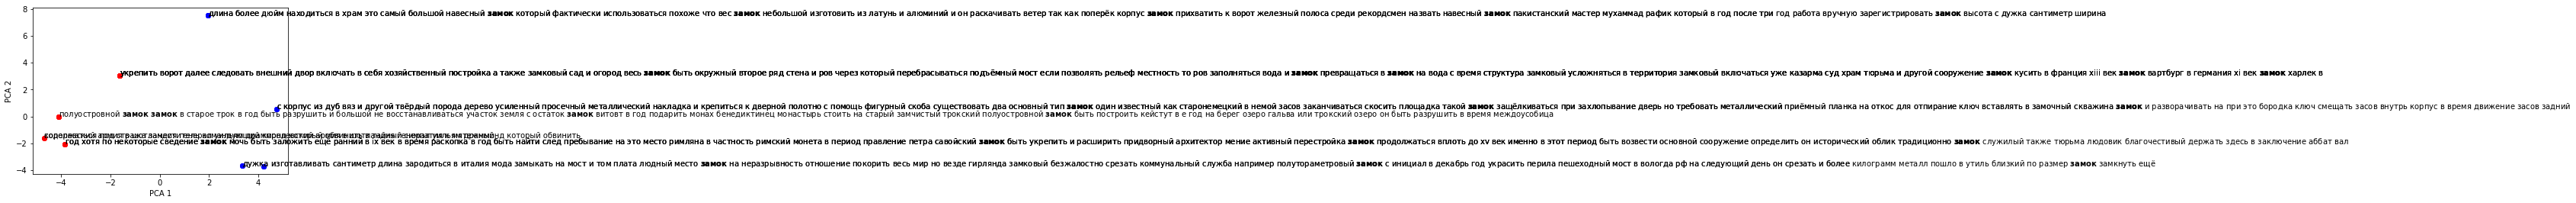

In [94]:
plot('замок', sentences, labels, X_reduce)

Что можно сделать с этими векторами в целях WSD?
* классификатор
* кластеризация

Попробуем разные методы кластеризации.

In [95]:
grouped_df = df.groupby('word')[['word', 'context', 'gold_sense_id']]

In [108]:
ARI = []

for key, _ in grouped_df:
    texts = grouped_df.get_group(key)['context']
    gold_labels = grouped_df.get_group(key)['gold_sense_id'].to_list()
    X = get_elmo_vectors(key, texts, model)
    if len(X) != len(gold_labels):
        continue
    
    cluster = AffinityPropagation(damping=0.9)
    cluster.fit(X)
    labels = np.array(cluster.labels_) + 1
    
    ARI.append(adjusted_rand_score(gold_labels, labels))
    
    print(key, '  ', adjusted_rand_score(gold_labels, labels))
print(np.mean(ARI))

2020-12-10 18:02:33,209 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:02:35,440 : INFO : Warming up finished.
2020-12-10 18:02:35,447 : INFO : Texts in the current batch: 32
2020-12-10 18:02:36,286 : INFO : Texts in the current batch: 32
2020-12-10 18:02:37,233 : INFO : Texts in the current batch: 32
2020-12-10 18:02:38,163 : INFO : Texts in the current batch: 23


балка    0.06647921321170024


2020-12-10 18:02:50,472 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:02:54,302 : INFO : Warming up finished.
2020-12-10 18:02:54,322 : INFO : Texts in the current batch: 32
2020-12-10 18:02:56,705 : INFO : Texts in the current batch: 24
2020-12-10 18:03:08,955 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:03:10,554 : INFO : Warming up finished.
2020-12-10 18:03:10,560 : INFO : Texts in the current batch: 32
2020-12-10 18:03:11,294 : INFO : Texts in the current batch: 32
2020-12-10 18:03:11,983 : INFO : Texts in the current batch: 13


вид    0.25664504465816335


2020-12-10 18:03:22,667 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:03:24,268 : INFO : Warming up finished.
2020-12-10 18:03:24,274 : INFO : Texts in the current batch: 32
2020-12-10 18:03:24,968 : INFO : Texts in the current batch: 32
2020-12-10 18:03:25,652 : INFO : Texts in the current batch: 32
2020-12-10 18:03:26,373 : INFO : Texts in the current batch: 27


винт    0.07523607178327468


2020-12-10 18:03:36,452 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:03:37,883 : INFO : Warming up finished.
2020-12-10 18:03:37,889 : INFO : Texts in the current batch: 32
2020-12-10 18:03:38,552 : INFO : Texts in the current batch: 19
2020-12-10 18:03:49,928 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:03:51,686 : INFO : Warming up finished.
2020-12-10 18:03:51,692 : INFO : Texts in the current batch: 32
2020-12-10 18:03:52,425 : INFO : Texts in the current batch: 32
2020-12-10 18:03:53,137 : INFO : Texts in the current batch: 32
2020-12-10 18:03:53,831 : INFO : Texts in the current batch: 32
2020-12-10 18:03:54,550 : INFO : Texts in the current batch: 9


губа    0.011203499312489646


2020-12-10 18:04:05,473 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:04:07,355 : INFO : Warming up finished.
2020-12-10 18:04:07,359 : INFO : Texts in the current batch: 32
2020-12-10 18:04:08,405 : INFO : Texts in the current batch: 4
2020-12-10 18:04:18,812 : INFO : Warming up ELMo on 15 sentences...
2020-12-10 18:04:19,864 : INFO : Warming up finished.
2020-12-10 18:04:19,866 : INFO : Texts in the current batch: 15
2020-12-10 18:04:30,866 : INFO : Warming up ELMo on 25 sentences...
2020-12-10 18:04:32,516 : INFO : Warming up finished.
2020-12-10 18:04:32,519 : INFO : Texts in the current batch: 25


двойник    -0.010005215989378346


2020-12-10 18:04:44,347 : INFO : Warming up ELMo on 13 sentences...
2020-12-10 18:04:45,693 : INFO : Warming up finished.
2020-12-10 18:04:45,695 : INFO : Texts in the current batch: 13


дворец    0.3486973947895791


2020-12-10 18:04:56,204 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:04:57,709 : INFO : Warming up finished.
2020-12-10 18:04:57,713 : INFO : Texts in the current batch: 32
2020-12-10 18:04:58,301 : INFO : Texts in the current batch: 15


девятка    0.10893567463738525


2020-12-10 18:05:09,580 : INFO : Warming up ELMo on 9 sentences...
2020-12-10 18:05:10,797 : INFO : Warming up finished.
2020-12-10 18:05:10,799 : INFO : Texts in the current batch: 9


дедушка    0.41558441558441556


2020-12-10 18:05:22,558 : INFO : Warming up ELMo on 12 sentences...
2020-12-10 18:05:23,900 : INFO : Warming up finished.
2020-12-10 18:05:23,902 : INFO : Texts in the current batch: 12
2020-12-10 18:05:36,334 : INFO : Warming up ELMo on 13 sentences...
2020-12-10 18:05:37,578 : INFO : Warming up finished.
2020-12-10 18:05:37,581 : INFO : Texts in the current batch: 13


дежурный    0.06185567010309281


2020-12-10 18:05:50,152 : INFO : Warming up ELMo on 11 sentences...
2020-12-10 18:05:51,473 : INFO : Warming up finished.
2020-12-10 18:05:51,476 : INFO : Texts in the current batch: 11


декабрист    0.013289036544850487


2020-12-10 18:06:01,813 : INFO : Warming up ELMo on 12 sentences...
2020-12-10 18:06:02,832 : INFO : Warming up finished.
2020-12-10 18:06:02,834 : INFO : Texts in the current batch: 12


декрет    0.5378151260504201


2020-12-10 18:06:13,493 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:06:15,211 : INFO : Warming up finished.
2020-12-10 18:06:15,215 : INFO : Texts in the current batch: 32
2020-12-10 18:06:16,143 : INFO : Texts in the current batch: 32
2020-12-10 18:06:17,044 : INFO : Texts in the current batch: 32
2020-12-10 18:06:17,691 : INFO : Texts in the current batch: 32
2020-12-10 18:06:18,364 : INFO : Texts in the current batch: 2
2020-12-10 18:06:28,584 : INFO : Warming up ELMo on 14 sentences...
2020-12-10 18:06:29,682 : INFO : Warming up finished.
2020-12-10 18:06:29,684 : INFO : Texts in the current batch: 14


демобилизация    0.2280439121756487


2020-12-10 18:06:39,601 : INFO : Warming up ELMo on 18 sentences...
2020-12-10 18:06:40,872 : INFO : Warming up finished.
2020-12-10 18:06:40,875 : INFO : Texts in the current batch: 18


демократ    0.0


2020-12-10 18:06:53,276 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:06:55,513 : INFO : Warming up finished.
2020-12-10 18:06:55,517 : INFO : Texts in the current batch: 32
2020-12-10 18:06:56,138 : INFO : Texts in the current batch: 6
2020-12-10 18:07:07,144 : INFO : Warming up ELMo on 21 sentences...
2020-12-10 18:07:08,410 : INFO : Warming up finished.
2020-12-10 18:07:08,413 : INFO : Texts in the current batch: 21


дерево    0.16254416961130744


2020-12-10 18:07:17,825 : INFO : Warming up ELMo on 15 sentences...
2020-12-10 18:07:18,851 : INFO : Warming up finished.
2020-12-10 18:07:18,854 : INFO : Texts in the current batch: 15


держава    0.09266409266409262


2020-12-10 18:07:29,285 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:07:31,133 : INFO : Warming up finished.
2020-12-10 18:07:31,138 : INFO : Texts in the current batch: 32
2020-12-10 18:07:32,095 : INFO : Texts in the current batch: 5


дерзость    0.0


2020-12-10 18:07:41,407 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:07:42,925 : INFO : Warming up finished.
2020-12-10 18:07:42,929 : INFO : Texts in the current batch: 32
2020-12-10 18:07:43,761 : INFO : Texts in the current batch: 4


десятка    0.04660732656438699


2020-12-10 18:07:54,258 : INFO : Warming up ELMo on 21 sentences...
2020-12-10 18:07:56,136 : INFO : Warming up finished.
2020-12-10 18:07:56,139 : INFO : Texts in the current batch: 21
2020-12-10 18:08:06,897 : INFO : Warming up ELMo on 14 sentences...
2020-12-10 18:08:08,015 : INFO : Warming up finished.
2020-12-10 18:08:08,017 : INFO : Texts in the current batch: 14


деятель    0.7130730050933786


2020-12-10 18:08:18,745 : INFO : Warming up ELMo on 14 sentences...
2020-12-10 18:08:20,036 : INFO : Warming up finished.
2020-12-10 18:08:20,040 : INFO : Texts in the current batch: 14


диалог    0.42882249560632685


2020-12-10 18:08:30,459 : INFO : Warming up ELMo on 18 sentences...
2020-12-10 18:08:31,782 : INFO : Warming up finished.
2020-12-10 18:08:31,786 : INFO : Texts in the current batch: 18


диаметр    -0.025802519301097133


2020-12-10 18:08:42,496 : INFO : Warming up ELMo on 25 sentences...
2020-12-10 18:08:43,843 : INFO : Warming up finished.
2020-12-10 18:08:43,846 : INFO : Texts in the current batch: 25


диплом    0.09793814432989689


2020-12-10 18:08:53,943 : INFO : Warming up ELMo on 11 sentences...
2020-12-10 18:08:55,002 : INFO : Warming up finished.
2020-12-10 18:08:55,004 : INFO : Texts in the current batch: 11


директор    -0.022576361221779515


2020-12-10 18:09:06,668 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:09:08,232 : INFO : Warming up finished.
2020-12-10 18:09:08,236 : INFO : Texts in the current batch: 32
2020-12-10 18:09:08,943 : INFO : Texts in the current batch: 31
2020-12-10 18:09:19,313 : INFO : Warming up ELMo on 18 sentences...
2020-12-10 18:09:20,564 : INFO : Warming up finished.
2020-12-10 18:09:20,566 : INFO : Texts in the current batch: 18


дичь    -0.04286770140428679


2020-12-10 18:09:29,425 : INFO : Warming up ELMo on 21 sentences...
2020-12-10 18:09:30,495 : INFO : Warming up finished.
2020-12-10 18:09:30,497 : INFO : Texts in the current batch: 21


длина    -0.08562197092084003


2020-12-10 18:09:38,778 : INFO : Warming up ELMo on 12 sentences...
2020-12-10 18:09:39,735 : INFO : Warming up finished.
2020-12-10 18:09:39,737 : INFO : Texts in the current batch: 12


доброволец    -0.054794520547945265


2020-12-10 18:09:49,575 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:09:50,919 : INFO : Warming up finished.
2020-12-10 18:09:50,922 : INFO : Texts in the current batch: 32
2020-12-10 18:09:51,515 : INFO : Texts in the current batch: 3


добыча    0.1644894172914734


2020-12-10 18:10:01,866 : INFO : Warming up ELMo on 24 sentences...
2020-12-10 18:10:03,491 : INFO : Warming up finished.
2020-12-10 18:10:03,495 : INFO : Texts in the current batch: 24


доказательство    0.07292912040990605


2020-12-10 18:10:15,920 : INFO : Warming up ELMo on 17 sentences...
2020-12-10 18:10:18,009 : INFO : Warming up finished.
2020-12-10 18:10:18,014 : INFO : Texts in the current batch: 17


доктор    0.1933751119068935


2020-12-10 18:10:28,973 : INFO : Warming up ELMo on 13 sentences...
2020-12-10 18:10:30,130 : INFO : Warming up finished.
2020-12-10 18:10:30,133 : INFO : Texts in the current batch: 13


долгота    -0.06557377049180323


2020-12-10 18:10:40,324 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:10:42,025 : INFO : Warming up finished.
2020-12-10 18:10:42,029 : INFO : Texts in the current batch: 32
2020-12-10 18:10:42,966 : INFO : Texts in the current batch: 13
2020-12-10 18:10:53,361 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:10:54,692 : INFO : Warming up finished.
2020-12-10 18:10:54,695 : INFO : Texts in the current batch: 32
2020-12-10 18:10:55,244 : INFO : Texts in the current batch: 6
2020-12-10 18:11:04,470 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:11:05,914 : INFO : Warming up finished.
2020-12-10 18:11:05,917 : INFO : Texts in the current batch: 32
2020-12-10 18:11:06,497 : INFO : Texts in the current batch: 15
2020-12-10 18:11:16,571 : INFO : Warming up ELMo on 22 sentences...
2020-12-10 18:11:17,923 : INFO : Warming up finished.
2020-12-10 18:11:17,927 : INFO : Texts in the current batch: 22


достижение    0.22129186602870815


2020-12-10 18:11:28,761 : INFO : Warming up ELMo on 16 sentences...
2020-12-10 18:11:29,968 : INFO : Warming up finished.
2020-12-10 18:11:29,971 : INFO : Texts in the current batch: 16


древесина    -0.08936170212765958


2020-12-10 18:11:41,434 : INFO : Warming up ELMo on 15 sentences...
2020-12-10 18:11:42,722 : INFO : Warming up finished.
2020-12-10 18:11:42,725 : INFO : Texts in the current batch: 15


дупло    0.011080332409972329


2020-12-10 18:11:53,513 : INFO : Warming up ELMo on 12 sentences...
2020-12-10 18:11:54,833 : INFO : Warming up finished.
2020-12-10 18:11:54,835 : INFO : Texts in the current batch: 12


дура    -0.06648199445983385


2020-12-10 18:12:05,995 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:12:07,641 : INFO : Warming up finished.
2020-12-10 18:12:07,645 : INFO : Texts in the current batch: 32
2020-12-10 18:12:08,423 : INFO : Texts in the current batch: 32
2020-12-10 18:12:09,164 : INFO : Texts in the current batch: 13
2020-12-10 18:12:18,145 : INFO : Warming up ELMo on 28 sentences...
2020-12-10 18:12:19,723 : INFO : Warming up finished.
2020-12-10 18:12:19,727 : INFO : Texts in the current batch: 28


дым    0.1997758475763519


2020-12-10 18:12:30,578 : INFO : Warming up ELMo on 18 sentences...
2020-12-10 18:12:31,880 : INFO : Warming up finished.
2020-12-10 18:12:31,883 : INFO : Texts in the current batch: 18


дымка    0.028571428571428564


2020-12-10 18:12:42,784 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:12:44,369 : INFO : Warming up finished.
2020-12-10 18:12:44,372 : INFO : Texts in the current batch: 32
2020-12-10 18:12:45,013 : INFO : Texts in the current batch: 24
2020-12-10 18:12:57,736 : INFO : Warming up ELMo on 22 sentences...
2020-12-10 18:12:59,390 : INFO : Warming up finished.
2020-12-10 18:12:59,394 : INFO : Texts in the current batch: 22


дьявол    0.11923743500866553


2020-12-10 18:13:09,427 : INFO : Warming up ELMo on 8 sentences...
2020-12-10 18:13:10,571 : INFO : Warming up finished.
2020-12-10 18:13:10,573 : INFO : Texts in the current batch: 8


евро    0.0


2020-12-10 18:13:22,329 : INFO : Warming up ELMo on 14 sentences...
2020-12-10 18:13:24,304 : INFO : Warming up finished.
2020-12-10 18:13:24,307 : INFO : Texts in the current batch: 14


езда    0.21401151631477927


2020-12-10 18:13:36,712 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:13:38,373 : INFO : Warming up finished.
2020-12-10 18:13:38,379 : INFO : Texts in the current batch: 32
2020-12-10 18:13:39,110 : INFO : Texts in the current batch: 32
2020-12-10 18:13:39,837 : INFO : Texts in the current batch: 32
2020-12-10 18:13:40,590 : INFO : Texts in the current batch: 25


жаба    0.02181015615011207


2020-12-10 18:13:52,136 : INFO : Warming up ELMo on 11 sentences...
2020-12-10 18:13:53,435 : INFO : Warming up finished.
2020-12-10 18:13:53,437 : INFO : Texts in the current batch: 11
2020-12-10 18:14:03,519 : INFO : Warming up ELMo on 11 sentences...
2020-12-10 18:14:04,623 : INFO : Warming up finished.
2020-12-10 18:14:04,627 : INFO : Texts in the current batch: 11


жало    0.020547945205479434


2020-12-10 18:14:15,921 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:14:17,620 : INFO : Warming up finished.
2020-12-10 18:14:17,624 : INFO : Texts in the current batch: 32
2020-12-10 18:14:18,426 : INFO : Texts in the current batch: 5


жертва    0.09852647959928028


2020-12-10 18:14:28,876 : INFO : Warming up ELMo on 14 sentences...
2020-12-10 18:14:30,050 : INFO : Warming up finished.
2020-12-10 18:14:30,053 : INFO : Texts in the current batch: 14


жестокость    -0.08149405772495757


2020-12-10 18:14:41,136 : INFO : Warming up ELMo on 12 sentences...
2020-12-10 18:14:42,318 : INFO : Warming up finished.
2020-12-10 18:14:42,320 : INFO : Texts in the current batch: 12


жидкость    -0.043360433604336


2020-12-10 18:14:52,848 : INFO : Warming up ELMo on 17 sentences...
2020-12-10 18:14:54,139 : INFO : Warming up finished.
2020-12-10 18:14:54,142 : INFO : Texts in the current batch: 17
2020-12-10 18:15:04,434 : INFO : Warming up ELMo on 16 sentences...
2020-12-10 18:15:05,674 : INFO : Warming up finished.
2020-12-10 18:15:05,677 : INFO : Texts in the current batch: 16
2020-12-10 18:15:15,333 : INFO : Warming up ELMo on 15 sentences...
2020-12-10 18:15:16,340 : INFO : Warming up finished.
2020-12-10 18:15:16,342 : INFO : Texts in the current batch: 15


жир    -0.06451612903225812


2020-12-10 18:15:26,140 : INFO : Warming up ELMo on 15 sentences...
2020-12-10 18:15:27,387 : INFO : Warming up finished.
2020-12-10 18:15:27,389 : INFO : Texts in the current batch: 15


жребий    0.4444444444444444


2020-12-10 18:15:37,998 : INFO : Warming up ELMo on 14 sentences...
2020-12-10 18:15:39,348 : INFO : Warming up finished.
2020-12-10 18:15:39,350 : INFO : Texts in the current batch: 14
2020-12-10 18:15:50,223 : INFO : Warming up ELMo on 16 sentences...
2020-12-10 18:15:51,602 : INFO : Warming up finished.
2020-12-10 18:15:51,606 : INFO : Texts in the current batch: 16


завещание    0.08333333333333333


2020-12-10 18:16:01,915 : INFO : Warming up ELMo on 21 sentences...
2020-12-10 18:16:03,340 : INFO : Warming up finished.
2020-12-10 18:16:03,343 : INFO : Texts in the current batch: 21


зависимость    0.13112667091024827


2020-12-10 18:16:13,505 : INFO : Warming up ELMo on 22 sentences...
2020-12-10 18:16:14,788 : INFO : Warming up finished.
2020-12-10 18:16:14,791 : INFO : Texts in the current batch: 22


заголовок    0.02746148693904889


2020-12-10 18:16:25,649 : INFO : Warming up ELMo on 26 sentences...
2020-12-10 18:16:27,216 : INFO : Warming up finished.
2020-12-10 18:16:27,220 : INFO : Texts in the current batch: 26


заготовка    0.09080312390721529


2020-12-10 18:16:37,794 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:16:39,422 : INFO : Warming up finished.
2020-12-10 18:16:39,427 : INFO : Texts in the current batch: 32
2020-12-10 18:16:40,054 : INFO : Texts in the current batch: 1


задание    0.3622258783347564


2020-12-10 18:16:50,428 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:16:51,951 : INFO : Warming up finished.
2020-12-10 18:16:51,954 : INFO : Texts in the current batch: 32
2020-12-10 18:16:52,622 : INFO : Texts in the current batch: 4


задача    0.03817476886370414


2020-12-10 18:17:02,906 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:17:04,756 : INFO : Warming up finished.
2020-12-10 18:17:04,760 : INFO : Texts in the current batch: 32
2020-12-10 18:17:05,721 : INFO : Texts in the current batch: 28
2020-12-10 18:17:16,100 : INFO : Warming up ELMo on 13 sentences...
2020-12-10 18:17:17,359 : INFO : Warming up finished.
2020-12-10 18:17:17,362 : INFO : Texts in the current batch: 13


зажигалка    0.036072144288577114


2020-12-10 18:17:27,898 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:17:29,324 : INFO : Warming up finished.
2020-12-10 18:17:29,327 : INFO : Texts in the current batch: 32
2020-12-10 18:17:29,938 : INFO : Texts in the current batch: 24


закон    0.1072302034457146


2020-12-10 18:17:39,911 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:17:41,197 : INFO : Warming up finished.
2020-12-10 18:17:41,201 : INFO : Texts in the current batch: 32
2020-12-10 18:17:41,797 : INFO : Texts in the current batch: 6
2020-12-10 18:17:51,662 : INFO : Warming up ELMo on 13 sentences...
2020-12-10 18:17:52,833 : INFO : Warming up finished.
2020-12-10 18:17:52,836 : INFO : Texts in the current batch: 13


заложник    0.06952965235173827


2020-12-10 18:18:02,273 : INFO : Warming up ELMo on 18 sentences...
2020-12-10 18:18:03,723 : INFO : Warming up finished.
2020-12-10 18:18:03,727 : INFO : Texts in the current batch: 18
2020-12-10 18:18:16,384 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:18:19,302 : INFO : Warming up finished.
2020-12-10 18:18:19,315 : INFO : Texts in the current batch: 32
2020-12-10 18:18:21,514 : INFO : Texts in the current batch: 32
2020-12-10 18:18:23,857 : INFO : Texts in the current batch: 32
2020-12-10 18:18:26,117 : INFO : Texts in the current batch: 32
2020-12-10 18:18:28,296 : INFO : Texts in the current batch: 10


замок    0.06390117789120352


2020-12-10 18:18:38,593 : INFO : Warming up ELMo on 11 sentences...
2020-12-10 18:18:39,815 : INFO : Warming up finished.
2020-12-10 18:18:39,817 : INFO : Texts in the current batch: 11
2020-12-10 18:18:49,923 : INFO : Warming up ELMo on 14 sentences...
2020-12-10 18:18:51,098 : INFO : Warming up finished.
2020-12-10 18:18:51,100 : INFO : Texts in the current batch: 14


запятая    0.0


2020-12-10 18:19:02,644 : INFO : Warming up ELMo on 13 sentences...
2020-12-10 18:19:03,940 : INFO : Warming up finished.
2020-12-10 18:19:03,943 : INFO : Texts in the current batch: 13


застой    0.44399185336048874


2020-12-10 18:19:14,562 : INFO : Warming up ELMo on 12 sentences...
2020-12-10 18:19:15,680 : INFO : Warming up finished.
2020-12-10 18:19:15,685 : INFO : Texts in the current batch: 12


затея    -0.10344827586206896


2020-12-10 18:19:25,711 : INFO : Warming up ELMo on 16 sentences...
2020-12-10 18:19:26,974 : INFO : Warming up finished.
2020-12-10 18:19:26,977 : INFO : Texts in the current batch: 16


затишье    0.0


2020-12-10 18:19:37,573 : INFO : Warming up ELMo on 12 sentences...
2020-12-10 18:19:38,914 : INFO : Warming up finished.
2020-12-10 18:19:38,916 : INFO : Texts in the current batch: 12


затмение    0.0


2020-12-10 18:19:50,119 : INFO : Warming up ELMo on 15 sentences...
2020-12-10 18:19:51,356 : INFO : Warming up finished.
2020-12-10 18:19:51,358 : INFO : Texts in the current batch: 15


затруднение    0.1350906095551895


2020-12-10 18:20:01,385 : INFO : Warming up ELMo on 22 sentences...
2020-12-10 18:20:02,699 : INFO : Warming up finished.
2020-12-10 18:20:02,702 : INFO : Texts in the current batch: 22


захоронение    0.0


2020-12-10 18:20:12,973 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:20:14,625 : INFO : Warming up finished.
2020-12-10 18:20:14,629 : INFO : Texts in the current batch: 32
2020-12-10 18:20:15,393 : INFO : Texts in the current batch: 8


звезда    0.2673117436229492


2020-12-10 18:20:25,818 : INFO : Warming up ELMo on 14 sentences...
2020-12-10 18:20:27,361 : INFO : Warming up finished.
2020-12-10 18:20:27,364 : INFO : Texts in the current batch: 14


звон    -0.0550724637681159


2020-12-10 18:20:38,371 : INFO : Warming up ELMo on 21 sentences...
2020-12-10 18:20:39,676 : INFO : Warming up finished.
2020-12-10 18:20:39,679 : INFO : Texts in the current batch: 21
2020-12-10 18:20:49,878 : INFO : Warming up ELMo on 23 sentences...
2020-12-10 18:20:51,230 : INFO : Warming up finished.
2020-12-10 18:20:51,233 : INFO : Texts in the current batch: 23
2020-12-10 18:21:00,266 : INFO : Warming up ELMo on 12 sentences...
2020-12-10 18:21:01,279 : INFO : Warming up finished.
2020-12-10 18:21:01,281 : INFO : Texts in the current batch: 12


злоупотребление    0.0


2020-12-10 18:21:10,667 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:21:12,271 : INFO : Warming up finished.
2020-12-10 18:21:12,274 : INFO : Texts in the current batch: 32
2020-12-10 18:21:13,035 : INFO : Texts in the current batch: 23


знак    0.06979070641493346


2020-12-10 18:21:23,059 : INFO : Warming up ELMo on 14 sentences...
2020-12-10 18:21:24,267 : INFO : Warming up finished.
2020-12-10 18:21:24,270 : INFO : Texts in the current batch: 14


знамя    0.2551757342320655


2020-12-10 18:21:35,386 : INFO : Warming up ELMo on 30 sentences...
2020-12-10 18:21:36,892 : INFO : Warming up finished.
2020-12-10 18:21:36,896 : INFO : Texts in the current batch: 30


значение    0.26902131632176757


2020-12-10 18:21:48,009 : INFO : Warming up ELMo on 9 sentences...
2020-12-10 18:21:49,024 : INFO : Warming up finished.
2020-12-10 18:21:49,028 : INFO : Texts in the current batch: 9


зонт    -0.012499999999999956


2020-12-10 18:22:00,828 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:22:02,399 : INFO : Warming up finished.
2020-12-10 18:22:02,405 : INFO : Texts in the current batch: 32
2020-12-10 18:22:03,119 : INFO : Texts in the current batch: 32
2020-12-10 18:22:03,832 : INFO : Texts in the current batch: 32
2020-12-10 18:22:04,536 : INFO : Texts in the current batch: 32
2020-12-10 18:22:05,266 : INFO : Texts in the current batch: 22


клетка    0.10562563509847385


2020-12-10 18:22:14,577 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:22:16,032 : INFO : Warming up finished.
2020-12-10 18:22:16,038 : INFO : Texts in the current batch: 32
2020-12-10 18:22:16,762 : INFO : Texts in the current batch: 32
2020-12-10 18:22:17,484 : INFO : Texts in the current batch: 27


крыло    0.23059789699044392


2020-12-10 18:22:29,374 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:22:31,435 : INFO : Warming up finished.
2020-12-10 18:22:31,443 : INFO : Texts in the current batch: 32
2020-12-10 18:22:32,261 : INFO : Texts in the current batch: 32
2020-12-10 18:22:32,954 : INFO : Texts in the current batch: 32
2020-12-10 18:22:33,672 : INFO : Texts in the current batch: 32
2020-12-10 18:22:34,392 : INFO : Texts in the current batch: 22


купюра    -0.011130781047003116


2020-12-10 18:22:45,125 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:22:46,785 : INFO : Warming up finished.
2020-12-10 18:22:46,791 : INFO : Texts in the current batch: 32
2020-12-10 18:22:47,690 : INFO : Texts in the current batch: 32
2020-12-10 18:22:48,497 : INFO : Texts in the current batch: 29
2020-12-10 18:22:59,118 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:23:00,609 : INFO : Warming up finished.
2020-12-10 18:23:00,616 : INFO : Texts in the current batch: 32
2020-12-10 18:23:01,482 : INFO : Texts in the current batch: 32
2020-12-10 18:23:02,318 : INFO : Texts in the current batch: 32
2020-12-10 18:23:03,019 : INFO : Texts in the current batch: 32
2020-12-10 18:23:03,705 : INFO : Texts in the current batch: 21
2020-12-10 18:23:14,697 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:23:16,093 : INFO : Warming up finished.
2020-12-10 18:23:16,099 : INFO : Texts in the current batch: 32
2020-12-10 18:23:16,796 : INFO : Texts in the current batc

лира    0.20545715029955716


2020-12-10 18:23:57,450 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:24:00,780 : INFO : Warming up finished.
2020-12-10 18:24:00,799 : INFO : Texts in the current batch: 32
2020-12-10 18:24:03,150 : INFO : Texts in the current batch: 32
2020-12-10 18:24:05,376 : INFO : Texts in the current batch: 32
2020-12-10 18:24:07,843 : INFO : Texts in the current batch: 14
2020-12-10 18:24:19,569 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:24:21,243 : INFO : Warming up finished.
2020-12-10 18:24:21,250 : INFO : Texts in the current batch: 32
2020-12-10 18:24:22,064 : INFO : Texts in the current batch: 32
2020-12-10 18:24:22,927 : INFO : Texts in the current batch: 1


мина    0.08448877407392058


2020-12-10 18:24:33,009 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:24:34,450 : INFO : Warming up finished.
2020-12-10 18:24:34,456 : INFO : Texts in the current batch: 32
2020-12-10 18:24:35,111 : INFO : Texts in the current batch: 32
2020-12-10 18:24:35,786 : INFO : Texts in the current batch: 32
2020-12-10 18:24:36,484 : INFO : Texts in the current batch: 25


мишень    0.10445262805490457


2020-12-10 18:24:49,052 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:24:50,687 : INFO : Warming up finished.
2020-12-10 18:24:50,693 : INFO : Texts in the current batch: 32
2020-12-10 18:24:51,411 : INFO : Texts in the current batch: 32
2020-12-10 18:24:52,167 : INFO : Texts in the current batch: 32
2020-12-10 18:24:52,968 : INFO : Texts in the current batch: 4


обед    0.04797500304311245


2020-12-10 18:25:03,786 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:25:05,269 : INFO : Warming up finished.
2020-12-10 18:25:05,275 : INFO : Texts in the current batch: 32
2020-12-10 18:25:05,976 : INFO : Texts in the current batch: 32
2020-12-10 18:25:06,673 : INFO : Texts in the current batch: 32
2020-12-10 18:25:07,396 : INFO : Texts in the current batch: 32
2020-12-10 18:25:08,130 : INFO : Texts in the current batch: 18


оклад    0.002499209848594987


2020-12-10 18:25:19,114 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:25:20,573 : INFO : Warming up finished.
2020-12-10 18:25:20,579 : INFO : Texts in the current batch: 32
2020-12-10 18:25:21,293 : INFO : Texts in the current batch: 32
2020-12-10 18:25:21,993 : INFO : Texts in the current batch: 32
2020-12-10 18:25:22,736 : INFO : Texts in the current batch: 32
2020-12-10 18:25:23,436 : INFO : Texts in the current batch: 20


опушка    0.02071859295161064


2020-12-10 18:25:35,367 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:25:36,899 : INFO : Warming up finished.
2020-12-10 18:25:36,906 : INFO : Texts in the current batch: 32
2020-12-10 18:25:37,603 : INFO : Texts in the current batch: 32
2020-12-10 18:25:38,305 : INFO : Texts in the current batch: 32
2020-12-10 18:25:39,141 : INFO : Texts in the current batch: 32
2020-12-10 18:25:39,832 : INFO : Texts in the current batch: 14


полис    -5.834749910896263e-05


2020-12-10 18:25:51,349 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:25:52,905 : INFO : Warming up finished.
2020-12-10 18:25:52,911 : INFO : Texts in the current batch: 32
2020-12-10 18:25:53,634 : INFO : Texts in the current batch: 32
2020-12-10 18:25:54,348 : INFO : Texts in the current batch: 32
2020-12-10 18:25:55,140 : INFO : Texts in the current batch: 32
2020-12-10 18:25:55,920 : INFO : Texts in the current batch: 16


пост    0.12283407332460511


2020-12-10 18:26:06,839 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:26:08,338 : INFO : Warming up finished.
2020-12-10 18:26:08,344 : INFO : Texts in the current batch: 32
2020-12-10 18:26:09,048 : INFO : Texts in the current batch: 32
2020-12-10 18:26:09,756 : INFO : Texts in the current batch: 32
2020-12-10 18:26:10,467 : INFO : Texts in the current batch: 32
2020-12-10 18:26:11,154 : INFO : Texts in the current batch: 8


поток    0.002997840203430462


2020-12-10 18:26:22,645 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:26:24,244 : INFO : Warming up finished.
2020-12-10 18:26:24,250 : INFO : Texts in the current batch: 32
2020-12-10 18:26:24,954 : INFO : Texts in the current batch: 32
2020-12-10 18:26:25,671 : INFO : Texts in the current batch: 32
2020-12-10 18:26:26,419 : INFO : Texts in the current batch: 32
2020-12-10 18:26:27,145 : INFO : Texts in the current batch: 18


проказа    0.04153634931852885


2020-12-10 18:26:39,713 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:26:41,309 : INFO : Warming up finished.
2020-12-10 18:26:41,315 : INFO : Texts in the current batch: 32
2020-12-10 18:26:42,026 : INFO : Texts in the current batch: 32
2020-12-10 18:26:42,730 : INFO : Texts in the current batch: 32
2020-12-10 18:26:43,477 : INFO : Texts in the current batch: 31


пропасть    0.14676044916347974


2020-12-10 18:26:55,372 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:26:56,950 : INFO : Warming up finished.
2020-12-10 18:26:56,956 : INFO : Texts in the current batch: 32
2020-12-10 18:26:57,711 : INFO : Texts in the current batch: 32
2020-12-10 18:26:58,451 : INFO : Texts in the current batch: 32
2020-12-10 18:26:59,210 : INFO : Texts in the current batch: 32
2020-12-10 18:26:59,930 : INFO : Texts in the current batch: 11


проспект    0.05487698315553946


2020-12-10 18:27:11,633 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:27:13,207 : INFO : Warming up finished.
2020-12-10 18:27:13,213 : INFO : Texts in the current batch: 32
2020-12-10 18:27:13,947 : INFO : Texts in the current batch: 32
2020-12-10 18:27:14,674 : INFO : Texts in the current batch: 32
2020-12-10 18:27:15,377 : INFO : Texts in the current batch: 32
2020-12-10 18:27:16,095 : INFO : Texts in the current batch: 15


пытка    -0.005727951275127827


2020-12-10 18:27:26,546 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:27:27,970 : INFO : Warming up finished.
2020-12-10 18:27:27,976 : INFO : Texts in the current batch: 32
2020-12-10 18:27:28,682 : INFO : Texts in the current batch: 32
2020-12-10 18:27:29,404 : INFO : Texts in the current batch: 32
2020-12-10 18:27:30,089 : INFO : Texts in the current batch: 24
2020-12-10 18:27:41,154 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:27:42,651 : INFO : Warming up finished.
2020-12-10 18:27:42,657 : INFO : Texts in the current batch: 32
2020-12-10 18:27:43,455 : INFO : Texts in the current batch: 32
2020-12-10 18:27:44,256 : INFO : Texts in the current batch: 32
2020-12-10 18:27:44,958 : INFO : Texts in the current batch: 32
2020-12-10 18:27:45,721 : INFO : Texts in the current batch: 16


среда    0.18837795653739944


2020-12-10 18:27:57,543 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:28:00,845 : INFO : Warming up finished.
2020-12-10 18:28:00,859 : INFO : Texts in the current batch: 32
2020-12-10 18:28:03,082 : INFO : Texts in the current batch: 32
2020-12-10 18:28:06,013 : INFO : Texts in the current batch: 32
2020-12-10 18:28:10,013 : INFO : Texts in the current batch: 32
2020-12-10 18:28:13,859 : INFO : Texts in the current batch: 7
2020-12-10 18:28:28,571 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:28:30,384 : INFO : Warming up finished.
2020-12-10 18:28:30,390 : INFO : Texts in the current batch: 32
2020-12-10 18:28:31,099 : INFO : Texts in the current batch: 32
2020-12-10 18:28:31,846 : INFO : Texts in the current batch: 32
2020-12-10 18:28:32,550 : INFO : Texts in the current batch: 25


хвост    0.07267165155171218


2020-12-10 18:28:46,267 : INFO : Warming up ELMo on 32 sentences...
2020-12-10 18:28:47,955 : INFO : Warming up finished.
2020-12-10 18:28:47,961 : INFO : Texts in the current batch: 32
2020-12-10 18:28:48,676 : INFO : Texts in the current batch: 32
2020-12-10 18:28:49,448 : INFO : Texts in the current batch: 32


штамп    0.0811555966944767
0.09770906126639806
